In [15]:
%load_ext autoreload
%autoreload 2

import pathlib
import pickle
import os

import numpy as np
import pandas as pd

from scipy import signal

import mne
from matplotlib import pyplot as plt

import constants
import dataset
import folders
import iter_topography_fork
import analysis_and_plotting_functions as aps



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
plt.rcParams['figure.figsize'] = [12,6]



In [19]:
# Load dataset into memory (if short of memory, use preload=False)
ds = dataset.DatasetReader(data_path=folders.database_path_car, preload=True)


C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  step_down_p=step_down_p
C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p


[............................................................] 100.00%  |
[0.001]
Mean F-score for cluster 7.35808719235693
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


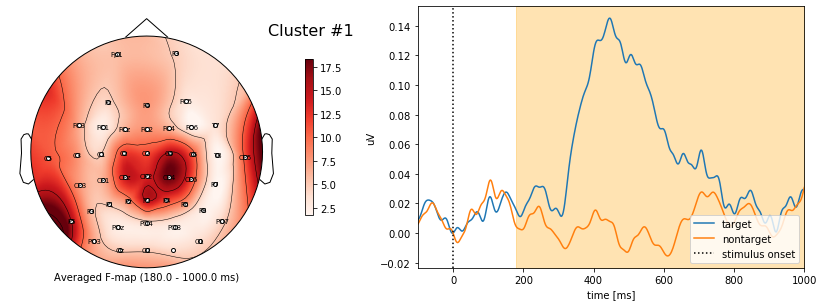

In [20]:
# target vs nontarget -- for illiustration of the method
target = []
nontarget = []
condition_names = ['target', 'nontarget']

for user in set(ds.markup['user']):
    subset_user= ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    ep=aps.subset(ds, subset_user)

    target.append(ep['target'].drop_channels(['ecg', 'A1', 'A2']))
    nontarget.append(ep['nontarget'].drop_channels(['ecg', 'A1', 'A2']))


X = [np.array([a.data.T for a in target]), 
     np.array([a.data.T for a in nontarget])]
info = nontarget[0].info
times = nontarget[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=1)


C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\parametric.py:129: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:420: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include),
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:421: RuntimeWarning: invalid value encountered in less
  np.logical_and(x < -thresh, include)]


[                                                            ]   0.00%  |
[0.012 0.01 ]
Mean F-score for cluster 3.912264637777116
Cluster channels ['Fp1', 'Fz', 'F4', 'FCz', 'FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8']


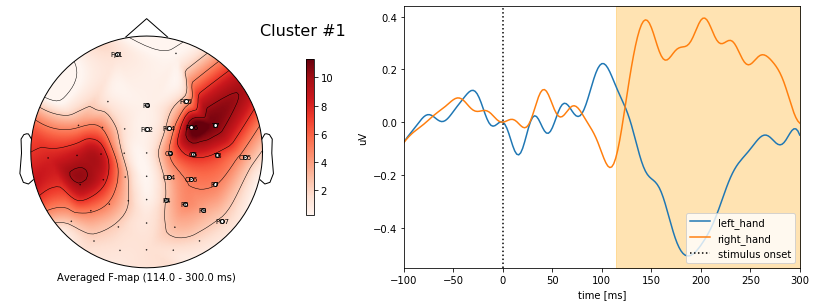

Mean F-score for cluster 4.223533936450177
Cluster channels ['F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1', 'Oz']


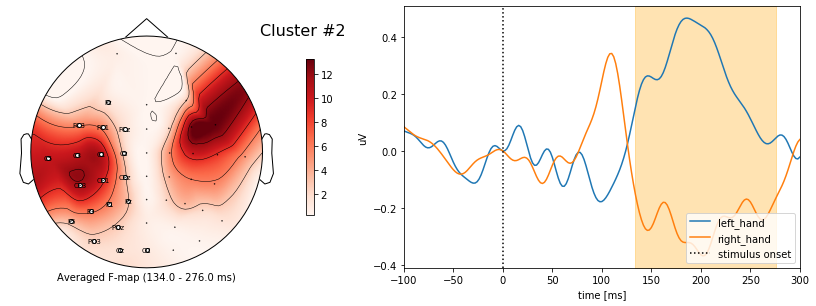

In [21]:
# nontarget right vs left for sighted
right_hand = []
left_hand = []
condition_names = ['left_hand', 'right_hand']

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']): 
    subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([7,6,5,4]))
                                ]

    subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([0,1,2,3]))
                                ]

    right_hand.append(aps.subset(ds, subset_right)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))
    left_hand.append(aps.subset(ds, subset_left)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))


X = [np.array([a.data.T for a in left_hand]), 
    np.array([a.data.T for a in right_hand])]
info = left_hand[0].info
times = left_hand[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=4)



[                                                            ]   0.00%  |

C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\parametric.py:129: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:420: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include),
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:421: RuntimeWarning: invalid value encountered in less
  np.logical_and(x < -thresh, include)]



[0.034 0.041]
Mean F-score for cluster 3.131700882872865
Cluster channels ['Fp1', 'F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'P5']


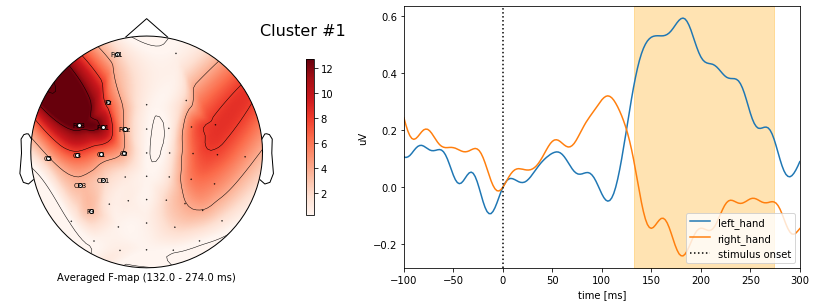

Mean F-score for cluster 3.286248048888916
Cluster channels ['F4', 'FC4', 'FC6', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4']


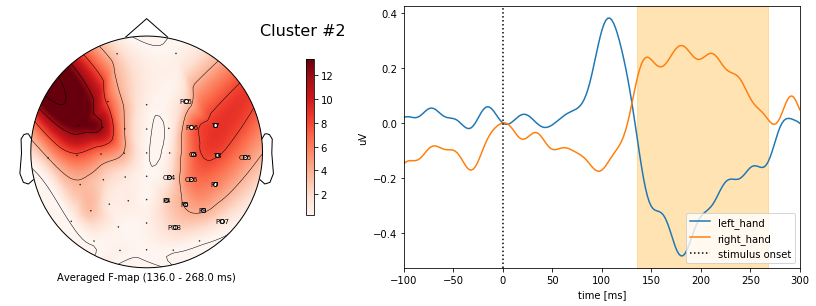

In [28]:
# nontarget right vs left for blind
right_hand = []
left_hand = []
condition_names = ['left_hand', 'right_hand']

for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']): 
    subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([7,6,5,4]))
                                ]

    subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([0,1,2,3]))
                                ]

    right_hand.append(aps.subset(ds, subset_right)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))
    left_hand.append(aps.subset(ds, subset_left)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))


X = [np.array([a.data.T for a in left_hand]), 
    np.array([a.data.T for a in right_hand])]
info = left_hand[0].info
times = left_hand[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=4)



[                                                            ]   0.00%  |

C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\parametric.py:129: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:420: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include),
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:421: RuntimeWarning: invalid value encountered in less
  np.logical_and(x < -thresh, include)]



[0.041 0.032 0.001 0.001]
Mean F-score for cluster 7.139988998584077
Cluster channels ['FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O2']


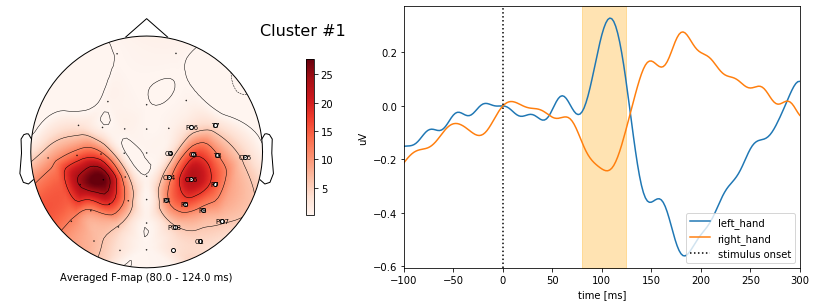

Mean F-score for cluster 6.900962721109457
Cluster channels ['FC5', 'T7', 'C5', 'C3', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1']


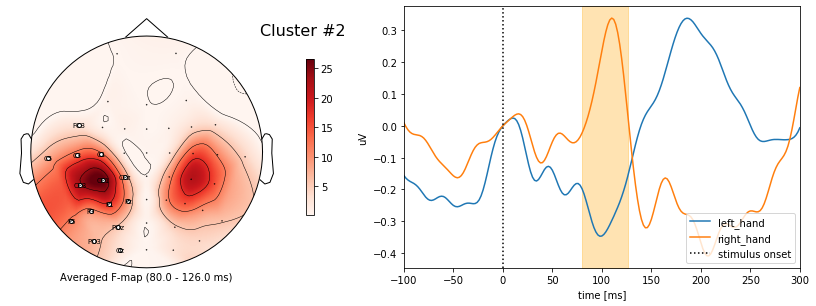

Mean F-score for cluster 5.54463697290687
Cluster channels ['Fp1', 'F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1']


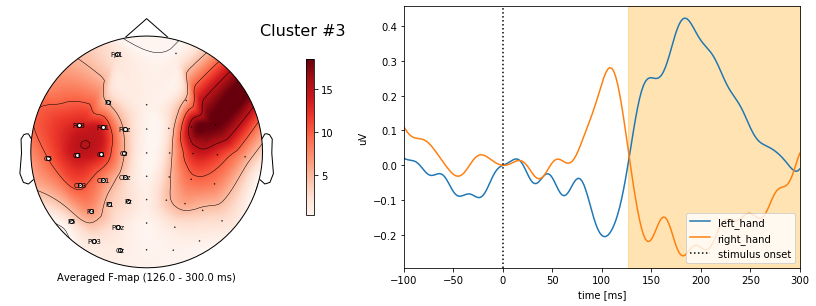

Mean F-score for cluster 5.54463697290687
Cluster channels ['F4', 'FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8']


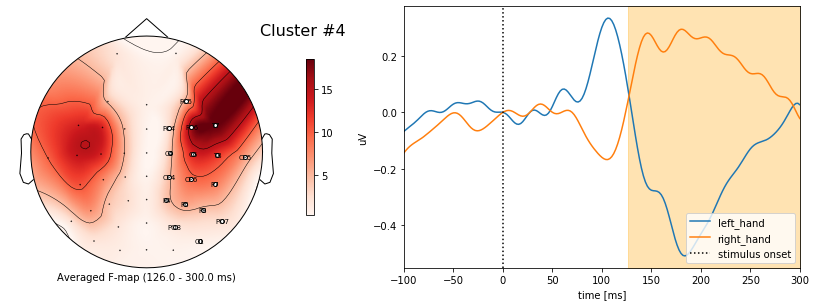

In [29]:
# nontarget right vs left for all
right_hand = []
left_hand = []
condition_names = ['left_hand', 'right_hand']

for user in set(ds.markup['user']):
    
    subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([7,6,5,4]))
                                ]

    subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([0,1,2,3]))
                                ]

    right_hand.append(aps.subset(ds, subset_right)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))
    left_hand.append(aps.subset(ds, subset_left)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))


X = [np.array([a.data.T for a in left_hand]), 
    np.array([a.data.T for a in right_hand])]
info = left_hand[0].info
times = left_hand[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=4)



In [30]:
# target blind vs sighted
blind = []
sighted = []
condition_names = ['blind', 'sighted']


for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    subset_blind = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    blind.append(aps.subset(ds, subset_blind)['delta'].crop(tmax=0.8).drop_channels(['ecg', 'A1', 'A2']))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    sighted.append(aps.subset(ds, subset_sighted)['delta'].crop(tmax=0.8).drop_channels(['ecg', 'A1', 'A2']))



X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=4)



[                                                            ]   0.00%  |

C:\Users\User\Miniconda3\lib\site-packages\mne\stats\parametric.py:129: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:425: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include)]



No significant clusters found


C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p


[............................................................] 100.00%  |
[0.001 0.022]
Mean F-score for cluster 3.8300911136055067
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4']


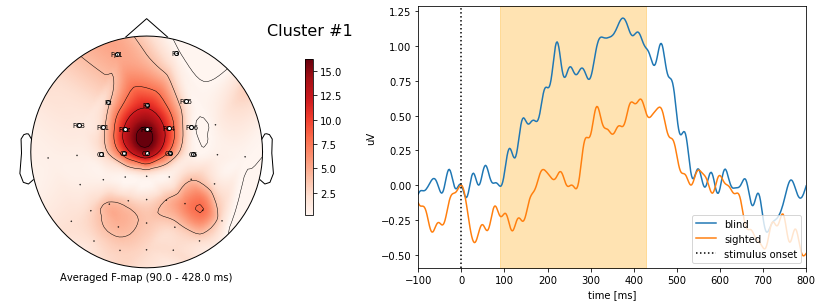

Mean F-score for cluster 3.600262358289258
Cluster channels ['FC6', 'C5', 'C6', 'CP5', 'CP3', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


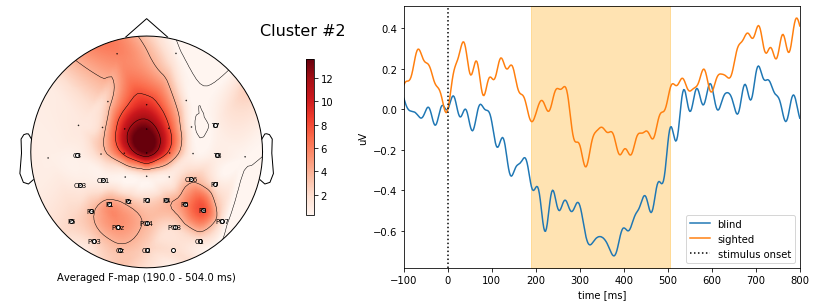

In [26]:
# target blind vs sighted - letter averaged
blind = []
sighted = []
condition_names = ['blind', 'sighted']


for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        blind.append(aps.subset(ds, subset_blind)['delta'].crop(tmax=0.8).drop_channels(['ecg', 'A1', 'A2']))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        sighted.append(aps.subset(ds, subset_sighted)['delta'].crop(tmax=0.8).drop_channels(['ecg', 'A1', 'A2']))


X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=1)


[                                                            ]   0.00%  |

C:\Users\User\Miniconda3\lib\site-packages\mne\stats\parametric.py:129: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:243: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  step_down_p=step_down_p
C:\Users\User\Miniconda3\lib\site-packages\mne\stats\cluster_level.py:425: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include)]


[............................................................] 100.00%  |
[0.001 0.014]
Mean F-score for cluster 4.089402135416585
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'CPz', 'CP2', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


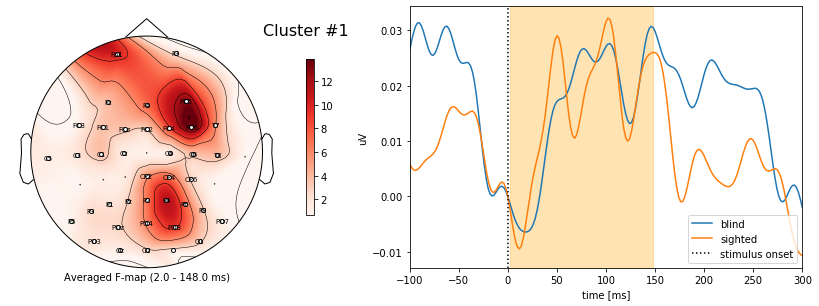

Mean F-score for cluster 2.48518511710449
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC3', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CPz', 'CP4', 'CP6', 'P7', 'P5', 'P6', 'PO7', 'PO3', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


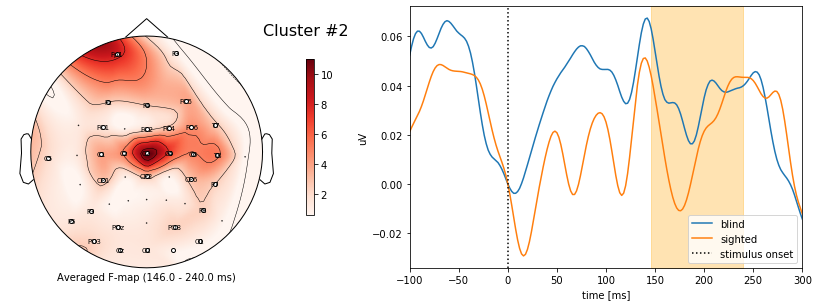

In [27]:
# nontarget blind vs sighted - letter averaged
blind = []
sighted = []
condition_names = ['blind', 'sighted']


for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        blind.append(aps.subset(ds, subset_blind)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        sighted.append(aps.subset(ds, subset_sighted)['nontarget'].crop(tmax=0.3).drop_channels(['ecg', 'A1', 'A2']))


X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=1)

